In [ ]:
import json
api_token = {"username":"iobananaoi","key":"0cbdda23beeb18cbb57e9e88bf26bfd1"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
import cv2
import os
import gc
import zipfile
import torch
import kaggle
import PIL
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
from torch import nn
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import Dataset, DataLoader
from functools import reduce
from datetime import date
from math import floor
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!kaggle datasets download -d romanleo2003/labtinkoff

100% 2.12G/2.13G [01:53<00:00, 25.4MB/s]
100% 2.13G/2.13G [01:53<00:00, 20.0MB/s]


In [ ]:
zip_ref = zipfile.ZipFile("/content/labtinkoff.zip", 'r')
zip_ref.extractall()

In [ ]:
for name in zip_ref.namelist():  
    old_name = "/content/" + name
    new_name = name.encode("cp437").decode('utf-8')

    zip_ref.extract(name) 
    os.rename(name, new_name) 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
batch_size = 32
epochs = 5

# Data processing

In [ ]:
class CCPD(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_pathes = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))][:100000]
        self.img_labels = [label.split("-")[1][:-4] for label in self.img_pathes][:100000]
        self.img_dir = img_dir 
        self.transform = transform 

        self.unique_symbols = set([s for label in self.img_labels for s in label])
        self.symb2idx = {list(self.unique_symbols)[i]: i+1 for i in range(len(self.unique_symbols))}
        self.idx2symb = {i+1: list(self.unique_symbols)[i] for i in range(len(self.unique_symbols))}
        
    def convert_label2idxs(self, label: str) -> list:
        return [self.symb2idx[symb] for symb in label]
    
    def convert_idxs2label(self, idxs: list) -> str:
        symbs_list = [self.idx2symb[idx.item()] for idx in idxs]
        return reduce(lambda x, y: x + y, symbs_list)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_pathes[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (100, 40))
        label = torch.tensor(self.convert_label2idxs(self.img_labels[idx]))
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [ ]:
train_data = CCPD("CCPD2019-dl1/train", transform=ToTensor())
test_data = CCPD("CCPD2019-dl1/test", transform=ToTensor())

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Features shape: torch.Size([32, 1, 40, 100])
皖AR1K19


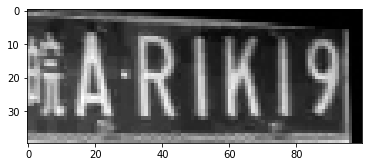

In [ ]:
example_features, example_labels = next(iter(train_dataloader))
img = example_features[0].squeeze()
label = example_labels[0]
print(f"Features shape: {example_features.shape}")
print(train_data.convert_idxs2label(label))
plt.imshow(img, cmap="gray")
plt.show()

# Model structure

In [ ]:
class Encoder(nn.Module):
    def __init__(self, dropout):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1), nn.BatchNorm2d(32),
            nn.PReLU(), nn.MaxPool2d(kernel_size=2, stride=1)) 
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1), nn.BatchNorm2d(64),  
            nn.PReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1), nn.BatchNorm2d(128), 
            nn.PReLU(), nn.MaxPool2d(kernel_size=2, stride=1))
        self.dropout = nn.Dropout(dropout)
        self.layer4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=2), nn.BatchNorm2d(128), 
            nn.PReLU(), nn.MaxPool2d(kernel_size=2, stride=1))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.reshape(x.shape[0], -1, x.shape[1]*x.shape[2])
        
        return x
     

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, num_classes, num_layers, dropout):
        super(Decoder, self).__init__()

        self.gru = nn.GRU(latent_dims, latent_dims, num_layers, dropout=dropout, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(latent_dims*2, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = torch.stack([nn.functional.log_softmax(self.linear(out[i]), dim=-1) for i in range(out.shape[0])])
        
        return out

In [ ]:
class CRNN(nn.Module):
    def __init__(self, latent_dims, batch_size, num_classes, rnn_layers=3, rnn_dropout=0.2, cnn_dropout=0.2):
        super(CRNN, self).__init__()

        self.encoder = Encoder(cnn_dropout)
        self.decoder = Decoder(latent_dims, num_classes, rnn_layers, rnn_dropout)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training part

In [ ]:
def train(model, dataloader, optimizer, loss_fn, last_batch):
    min_loss = 0
    model.train()
    for epoch in range(epochs):
        avg_loss = 0
        print(f"======== Epoch {epoch+1} ========")

        for batch, (img, label) in enumerate(dataloader):
            if batch <= last_batch:
                img, label = img.to(device), label.to(device)

                pred = model(img) # pred.shape == torch.Size([16, 49, 67])
                pred = pred.permute(1, 0, 2) 
                

                input_lengths = torch.IntTensor(batch_size).fill_(pred.shape[1])
                target_lengths = torch.IntTensor([len(t) for t in label])
                loss = loss_fn(pred, label, input_lengths, target_lengths)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 2)

                optimizer.step()

                avg_loss += loss
        avg_loss /= last_batch+1
        print(f"Epoch {epoch+1} completed. Average loss: {avg_loss:.5f}")
        if avg_loss >= min_loss * 1.15 and epoch > epochs//2:
            break
        else:
            min_loss = avg_loss
    
    model_file_name = f"d{date.today()}l{min_loss:.5f}.pth"
    torch.save(model.state_dict(), model_file_name)
    print(f"The model was saved with the best loss: {min_loss:.5f}")    

In [ ]:
num_classes = len(train_data.unique_symbols) + 1 # Reserve one more for blank symbol
blank_label = num_classes -1
last_batch = floor(len(train_data) / batch_size)
last_batch

3125

In [ ]:
model = CRNN(2432, batch_size, num_classes, rnn_layers=2, rnn_dropout=0.25, cnn_dropout=0.25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

178059142

In [ ]:
gc.collect()
torch.cuda.empty_cache()
train(model, train_dataloader, optimizer, loss_fn, last_batch)

======== Epoch 1 ========
Epoch 1 completed. Average loss: 0.91733
======== Epoch 2 ========
Epoch 2 completed. Average loss: 0.07981
======== Epoch 3 ========
Epoch 3 completed. Average loss: 0.06883
======== Epoch 4 ========
Epoch 4 completed. Average loss: 0.06631
======== Epoch 5 ========
Epoch 5 completed. Average loss: 0.06653
The model was saved with the best loss: 0.06653


# Testing part

In [ ]:
def test(model, dataloader):
    size = len(dataloader.dataset)
    model.eval()
    num_batches = batch_size

    test_loss, correct = 0, 0
    i = 0
    with torch.no_grad():
        for X, y in dataloader:
            if i == 156:
                break
            i += 1
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = pred.permute(1, 0, 2)

            ctc_loss = nn.CTCLoss(zero_infinity=True)
            input_lengths = torch.IntTensor(batch_size).fill_(23)
            target_lengths = torch.full(size=(batch_size,), fill_value=7, dtype=torch.long)
            test_loss += ctc_loss(pred, y, input_lengths, target_lengths).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")